# Introduction to Minuit2.jl

by Pere Mato, CERN

In [1]:
using Revise
using Minuit2
using Plots
using Polynomials

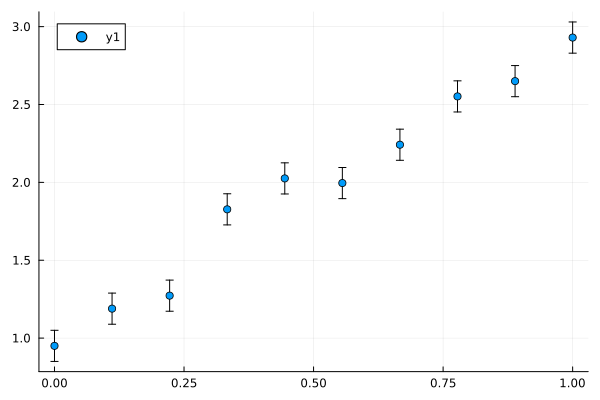

In [2]:
# let's make a line model
line(x, a, b) = a + x * b

a_true = 1.0
b_true = 2.0

# let's make some data
x = range(0, 1., 10)

# precomputed random numbers from standard normal distribution
z = [-0.49783783, -0.33041722, -1.71800806,  1.60229399,
      1.36682387, -1.15424221, -0.91425267, -0.03395604,
      -1.27611719, -0.7004073 ]

sigma_y = 0.1
y = line.(x, a_true, b_true) + sigma_y * z

# Plot with error bars
plot(x, y, yerr=sigma_y, seriestype=:scatter)

- Want to estimate parameters  (𝑎,𝑏)  of line model from data
- Need score which is minimal when model best agrees with data
    - Sum of residuals squared (least-squares method)
    - Negated sum of log-likelihood values (maximum-likelihood method)
- MINUIT always minimizes; negate score function to maximize
- Use iminuit to numerically minimize score as function of model parameters

In [3]:
LSQ(a, b) = sum((y - line.(x, a, b)) .^ 2 ./ sigma_y .^ 2)

LSQ (generic function with 1 method)

In [4]:
# create instance of Minuit and pass score function to minimize
m = Minuit(LSQ; a=2, b=5, fix_a=true,
                error_a=0.1, error_b=0.1,
                errordef=1)

Minuit(FCN = LSQ(a, b), X0 = [2, 5], Method = migrad)

In [5]:
migrad!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ up                 │
│ 305.114      │ migrad       │ 13        │ 3          │ 1.0                │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │            │ Reached call limit │
│ true         │ true         │ false     │            │ false              │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced             │
│ false        │ true         │ true      │ true       │ false              │
└──────────────┴──────────────┴───────────┴────────────┴────────────────────┘
┌──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────┐
│ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed │
├──────┼──────────┼─────────────┼────────┼────────┼────────┼────

Plot the obtained result

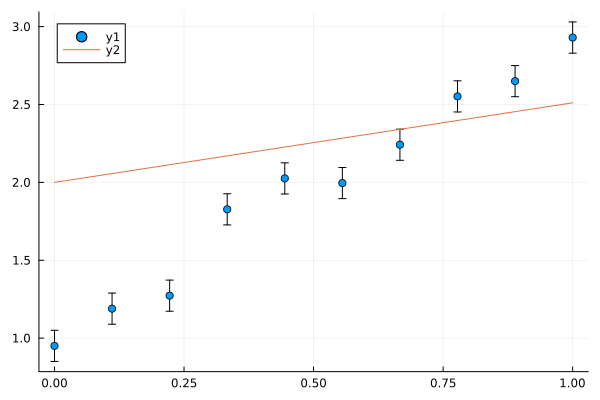

In [6]:
# get parameter values
a_fit, b_fit = values(m)

# Plot with error bars
plot(x, y, yerr=sigma_y, seriestype=:scatter)
plot!(x, line.(x, a_fit, b_fit))

In [7]:
# create instance of Minuit and pass score function to minimize
m = Minuit(LSQ; a=5, b=5, error_a=0.1, error_b=0.1,
                limit_a=(0, Inf), limit_b=(0, 10.), errordef=1)

Minuit(FCN = LSQ(a, b), X0 = [5, 5], Method = migrad)

In [8]:
migrad!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ up                 │
│ 10.387       │ migrad       │ 64        │ 8          │ 1.0                │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │            │ Reached call limit │
│ true         │ true         │ false     │            │ false              │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced             │
│ false        │ true         │ true      │ true       │ false              │
└──────────────┴──────────────┴───────────┴────────────┴────────────────────┘
┌──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────┐
│ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed │
├──────┼──────────┼─────────────┼────────┼────────┼────────┼────

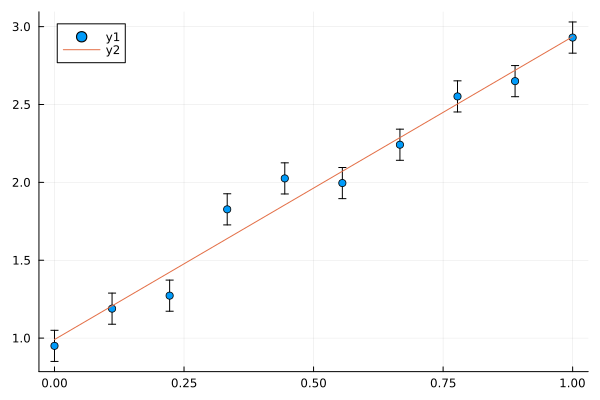

In [9]:
# get parameter values
a_fit, b_fit = values(m)

# Plot with error bars
plot(x, y, yerr=sigma_y, seriestype=:scatter)
plot!(x, line.(x, a_fit, b_fit))

## Fit of model with flexible number of parameters
- Sometimes the model has large or variable number of parameters
- Example: fit a polynomial of degree 2, 3, 4, ... ?
- Minuit2 has alternative interface which passes parameters as `AbstractVector` to score function

In [10]:
function LSQ_v(par)   # par is a vector of parameters
    pol = Polynomial(par) # for len(par) == 2 this is a line
    sum((y - pol.(x)) .^ 2 ./ sigma_y .^ 2)
end
# This is the order of coefficients in the polynomial (reverse order in np.polyval)
Polynomial([1,2,3,4])

Polynomial(1 + 2*x + 3*x^2 + 4*x^3)

In [11]:
# create instance of Minuit and pass score function to minimize
m = Minuit(LSQ_v, [5, 5], error=[0.1, 0.1], errordef=1)

Minuit(FCN = LSQ_v(par), X0 = [5, 5], Method = migrad)

In [12]:
migrad!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ up                 │
│ 10.387       │ migrad       │ 32        │ 4          │ 1.0                │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │            │ Reached call limit │
│ true         │ true         │ false     │            │ false              │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced             │
│ false        │ true         │ true      │ true       │ false              │
└──────────────┴──────────────┴───────────┴────────────┴────────────────────┘
┌────────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────┐
│ Name   │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed │
├────────┼──────────┼─────────────┼────────┼────────┼───────

names are automatically assigned to the name of the single argument

In [13]:
m = Minuit(LSQ_v, [2, 1, 3, 5], error=0.1,
           names=("a", "b", "c", "d"), errordef=1)

Minuit(FCN = LSQ_v(par), X0 = [2, 1, 3, 5], Method = migrad)

In [14]:
migrad!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ up                 │
│ 9.03319      │ migrad       │ 96        │ 7          │ 1.0                │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │            │ Reached call limit │
│ true         │ true         │ false     │            │ false              │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced             │
│ false        │ true         │ true      │ true       │ false              │
└──────────────┴──────────────┴───────────┴────────────┴────────────────────┘
┌──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────┐
│ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed │
├──────┼──────────┼─────────────┼────────┼────────┼────────┼────

Lets plot the resulted fit

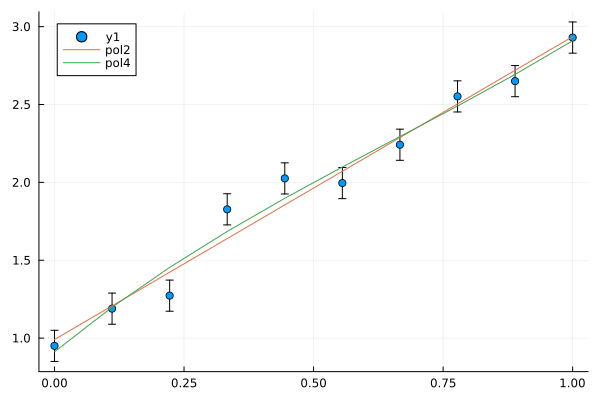

In [15]:
# get parameter values
par_fit = values(m)
pol = Polynomial(par_fit)

# Plot with error bars
plot(x, y, yerr=sigma_y, seriestype=:scatter)
plot!(x, line.(x, a_fit, b_fit), label="pol2")
plot!(x, pol.(x), label="pol4")

In [16]:
# check reduced chi2, goodness-of-fit estimate, should be around 1
fval(m) / (length(y) - length(values(m)))

1.5055320143296254

## Parameter uncertainties
- Minuit2 can compute symmetric uncertainty intervals ("Hesse errors")
    - automatically done during standard minimisation
    - to make sure you get accurate errors, call hesse!(m) explicitly after migrad!(m)
    - slow, computation time scales with  𝑁par^2 
- Minuit2 can also compute asymmetric uncertainty intervals ("Minos errors")
    - need to explicitly call m.minos()
    - very slow, computation time scales with  𝑁par^2 

In [17]:
# Call hesse to get parameter errors
hesse!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ up                 │
│ 9.03319      │ migrad       │ 119       │ 8          │ 1.0                │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │            │ Reached call limit │
│ true         │ true         │ false     │            │ false              │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced             │
│ false        │ true         │ true      │ true       │ false              │
└──────────────┴──────────────┴───────────┴────────────┴────────────────────┘
┌──────┬──────────┬─────────────┬────────┬────────┬────────┬────────┬───────┐
│ Name │ Value    │ Hesse Error │ Minos- │ Minos+ │ Limit- │ Limit+ │ Fixed │
├──────┼──────────┼─────────────┼────────┼────────┼────────┼────

In [18]:
# Get the covariance matrix
matrix(m)

4×4 Matrix{Float64}:
  0.00823777  -0.0571679   0.107622  -0.0594756
 -0.0571679    0.69139    -1.5931     0.979222
  0.107622    -1.5931      3.99548   -2.58081
 -0.0594756    0.979222   -2.58081    1.72054

In [19]:
# Get the correlation matrix
matrix(m, correlation=true)

4×4 Matrix{Float64}:
  1.0       -0.757505   0.593217  -0.499576
 -0.757505   1.0       -0.958507   0.897815
  0.593217  -0.958507   1.0       -0.984327
 -0.499576   0.897815  -0.984327   1.0

## Asymmetric uncertainty intervals from Minos

In [20]:
minos!(m)

┌──────────────┬──────────────┬───────────┬────────────┬────────────────────┐
│ FCN          │ Method       │ Ncalls    │ Iterations │ up                 │
│ 9.03319      │ migrad       │ 119       │ 8          │ 1.0                │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Valid Min.   │ Valid Param. │ Above EDM │            │ Reached call limit │
│ true         │ true         │ false     │            │ false              │
├──────────────┼──────────────┼───────────┼────────────┼────────────────────┤
│ Hesse failed │ Has cov.     │ Accurate  │ Pos. def.  │ Forced             │
│ false        │ true         │ true      │ true       │ false              │
└──────────────┴──────────────┴───────────┴────────────┴────────────────────┘
┌──────┬──────────┬─────────────┬────────────┬───────────┬────────┬────────┬────
│ Name │ Value    │ Hesse Error │ Minos-     │ Minos+    │ Limit- │ Limit+ │ F ⋯
├──────┼──────────┼─────────────┼────────────┼───────────┼

In [21]:
minos(m) |> show;

┌──────────┬──────────┬─────────┐
│ c        │ valid    │         │
├──────────┼──────────┼─────────┤
│ Error    │ -1.99887 │ 1.99887 │
│ Valid    │ true     │ true    │
│ At Limit │ false    │ false   │
│ Max Fcn  │ false    │ false   │
│ New Min  │ false    │ false   │
└──────────┴──────────┴─────────┘
┌──────────┬───────────┬──────────┐
│ b        │ valid     │          │
├──────────┼───────────┼──────────┤
│ Error    │ -0.831499 │ 0.831499 │
│ Valid    │ true      │ true     │
│ At Limit │ false     │ false    │
│ Max Fcn  │ false     │ false    │
│ New Min  │ false     │ false    │
└──────────┴───────────┴──────────┘
┌──────────┬────────────┬───────────┐
│ a        │ valid      │           │
├──────────┼────────────┼───────────┤
│ Error    │ -0.0907621 │ 0.0907621 │
│ Valid    │ true       │ true      │
│ At Limit │ false      │ false     │
│ Max Fcn  │ false      │ false     │
│ New Min  │ false      │ false     │
└──────────┴────────────┴───────────┘
┌──────────┬──────────┬─────

Minos can fail, check messages:
- "Valid": everything is chipper
- "At Limit": Minos hit parameter limit before finishing contour
- "Max FCN": Minos reached call limit before finishing contour
- "New Min": Minos found a new minimum while scanning

In [22]:
# Get the Minos parameter errors
d = minos(m, "d")
minos(m, "d").lower, minos(m, "d").upper
lower(d), upper(d)

(-1.3116943082332286, 1.3116943080735233)

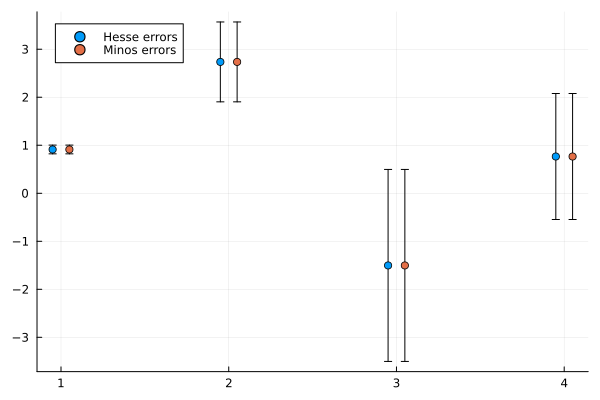

In [23]:
# plot parameters with errors
v = values(m)
ve = errors(m)
vm = merrors(m)

npar = length(v)
indices = 1:npar

# plot hesse errors
plot(indices .- 0.05, v, yerr=ve, seriestype=:scatter, label="Hesse errors")

# plot minos errors
plot!(indices .+ 0.05, v, yerr=(upper.(vm) - lower.(vm))/2, seriestype=:scatter, label="Minos errors")

## Builtin plotting

In [49]:
xv, yv, zv = Minuit2.contour(m, "d", "c", bound=4)

(-4.481301836010673:0.21415417687882:6.012252831051506, -9.498529728486515:0.32634614098500014:6.492431179778491, [37184.699871057244 35289.2883004685 … 2355.3835236824957 2849.352337812252; 36078.69590752313 34211.885209515196 … 2622.221444026547 3144.7911307370987; … ; 3144.791130737791 2622.2214440272146 … 34211.885209514774 36078.69590752269; 2849.3523378129494 2355.3835236831683 … 35289.28830046809 37184.6998710568])

In [46]:
xv

-5.7929961693934455:0.267692721098525:7.323947164434278

Any[2332.512359521612, 9302.949861828627, 20920.345699007026, 37184.6998710568]

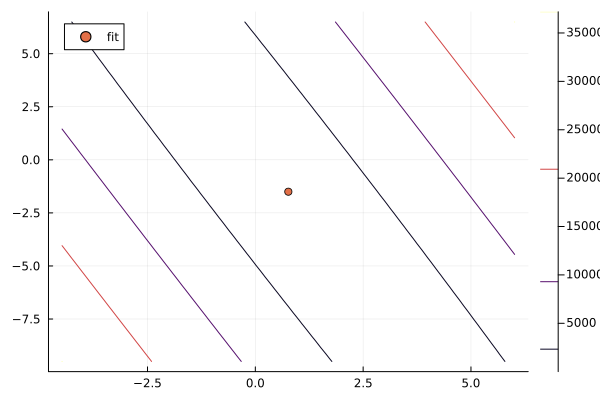

In [54]:
using CxxWrap
nsigmas = 4
ix, iy = 4, 3
values_v = StdVector(values(m))
errors_v = errors(m)
levels = []
for i in 1:nsigmas
    values_v[ix] = values(m)[ix] + i * errors_v[ix]
    values_v[iy] = values(m)[iy] + i * errors_v[iy]
    push!(levels, paren(m.fcn, values_v))
end
show(levels)
Plots.contour(xv, yv, zv, levels=levels)
Plots.scatter!(fit[ix:ix], fit[iy:iy], label="fit")